int64_list allows you to serialize integers or a list of integers. However, it will fail if you try to serialize something more complex - e.g. a list of lists (image). Therefore, converting your images into a string is a better choice. The only problem with this approach is restoration process. Effectively, once you convert you string back into integers, you get a list of integers without any shape. However, you can restore the shape, if you know dimensions! Thus, we need to store the dimensions of the image.
tf.reshape takes images dimensions only in tf.int32 format.

What is the deciding factor for resizing of image?

In [1]:
from random import shuffle
import glob
import cv2
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
shuffle_data = True  # shuffle the addresses before saving
cat_dog_train_path = r'C:\Users\MAHE\Desktop\CDAC\train_dataset\train\*.jpg'
# read addresses and labels from the 'train' folder
addrs = glob.glob(cat_dog_train_path) # glob.glob -> returns a list of path names
labels = [0 if 'cat' in addr else 1 for addr in addrs]  # 0 = Cat, 1 = Dog
# to shuffle data
if shuffle_data:
    c = list(zip(addrs, labels)) #zip -> creates an iterator that aggregates elements from addrs and labels
    shuffle(c)
    addrs, labels = zip(*c) #unzipping 
    
# Divide the hata into 60% train, 20% validation, and 20% test
train_addrs = addrs[0:int(0.6*len(addrs))]
train_labels = labels[0:int(0.6*len(labels))]
val_addrs = addrs[int(0.6*len(addrs)):int(0.8*len(addrs))]
val_labels = labels[int(0.6*len(addrs)):int(0.8*len(addrs))]
test_addrs = addrs[int(0.8*len(addrs)):]
test_labels = labels[int(0.8*len(labels)):]

In [3]:
def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr) # read image from path
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) # resizing to make all images of same size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image color from BGR(default) to RGB
    #tensorflow models use RGB format
    img = img.astype(np.float32) # copy of image np float array
    return img

In [4]:
# convert value to int64 list and assign it to Feature's value
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# convert value to byteslist and assign it to Feature's value
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [5]:
train_filename = 'train.tfrecords'  # address to save the TFRecords file
# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)

for i in range(len(train_addrs)): #for each image...
    # print how many images are saved every 1000 images (progress check)
    if not i % 1000:
        print('Train data: {}/{}'.format(i, len(train_addrs)))
        sys.stdout.flush()
    # Load the image
    img = load_image(train_addrs[i]) # img -> np float array of 'i'th image
    label = train_labels[i] # label -> label of 'i'th image
    
    if i==0 :
         print(img.shape)
    
    # Create a feature (actually of structure Features containing 2 Feature)
    feature = {'train/label': _int64_feature(label), #converting label to int64, assigning it to Feature1's value
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))} # converting np float array of image to string
                #string to byteslist, assigning byteslist to Feature2's value
    
    # Create an example protocol buffer
    # Convert features to Features, create an Example containing this Features
    example = tf.train.Example(features=tf.train.Features(feature=feature)) 
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

Train data: 0/15000
(224, 224, 3)
Train data: 1000/15000
Train data: 2000/15000
Train data: 3000/15000
Train data: 4000/15000
Train data: 5000/15000
Train data: 6000/15000
Train data: 7000/15000
Train data: 8000/15000
Train data: 9000/15000
Train data: 10000/15000
Train data: 11000/15000
Train data: 12000/15000
Train data: 13000/15000
Train data: 14000/15000


In [6]:
# open the TFRecords file
val_filename = 'val.tfrecords'  # address to save the TFRecords file
writer = tf.python_io.TFRecordWriter(val_filename)
for i in range(len(val_addrs)):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print('Val data: {}/{}'.format(i, len(val_addrs)))
        sys.stdout.flush()
    # Load the image
    img = load_image(val_addrs[i])
    label = val_labels[i]
    # Create a feature
    feature = {'val/label': _int64_feature(label),
               'val/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
writer.close()
sys.stdout.flush()
# open the TFRecords file
test_filename = 'test.tfrecords'  # address to save the TFRecords file
writer = tf.python_io.TFRecordWriter(test_filename)
for i in range(len(test_addrs)):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print('Test data: {}/{}'.format(i, len(test_addrs)))
        sys.stdout.flush()
    # Load the image
    img = load_image(test_addrs[i])
    label = test_labels[i]
    # Create a feature
    feature = {'test/label': _int64_feature(label),
               'test/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
writer.close()
sys.stdout.flush()

Val data: 0/5000
Val data: 1000/5000
Val data: 2000/5000
Val data: 3000/5000
Val data: 4000/5000
Test data: 0/5000
Test data: 1000/5000
Test data: 2000/5000
Test data: 3000/5000
Test data: 4000/5000


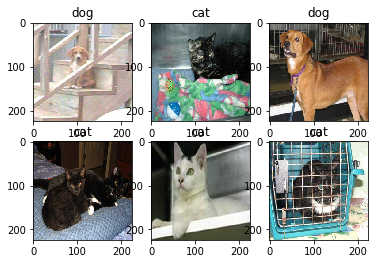

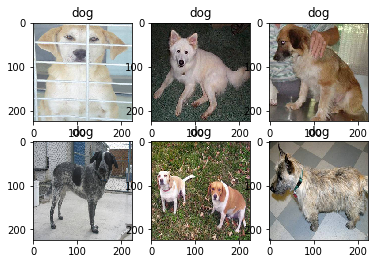

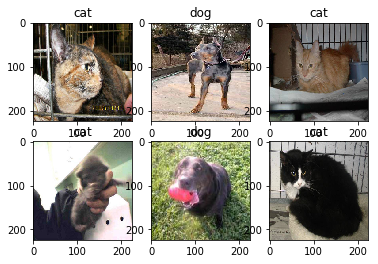

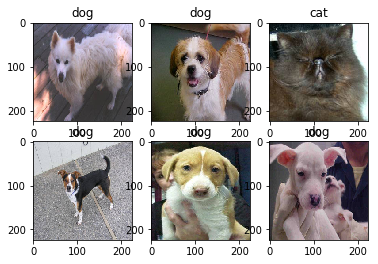

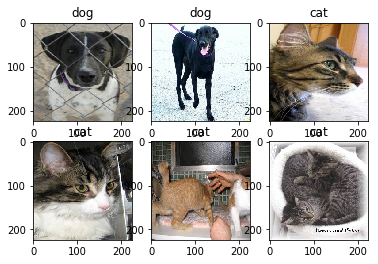

In [7]:
data_path = 'train.tfrecords'  # address to save the hdf5 file
with tf.Session() as sess:
    
    #actaully structure of a Features (contains 2 Feature)
    feature = {'train/image': tf.FixedLenFeature([], tf.string), #configuration for parsing a fixed length input feature
               'train/label': tf.FixedLenFeature([], tf.int64)}  #configuration for parsing a fixed length input feature
    
    # Create a list of filenames(strings) and pass it to a queue for input pipeline
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1) #specify n_epochs as it's None by default
    # (just one file -> train.tfrecords)
    
    # Define a reader and read the next record
    reader = tf.TFRecordReader() #outputs records from a tfrecord file
    _, serialized_example = reader.read(filename_queue) #returns next record (key, value)
    # _ : (key) name of record (useless)
    # serialized_example : (value) as the name says, it's a string (example is serialized)
    
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature) #parses a single example proto, returns Features
    #it takes a serialized example and a **dictionary whih maps feature keys to tensor values**(Features structure)
    
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['train/image'], tf.float32) # image is a float array, value of Feature1
    # Tensor("DecodeRaw_1:0", shape=(?,), dtype=float32)
    
    # Cast label data into int32
    label = tf.cast(features['train/label'], tf.int32) # label is an int variable , value of Feature2
    
    # Reshape image data into the original shape
    image = tf.reshape(image, [224, 224, 3])
    # Tensor("Reshape_1:0", shape=(224, 224, 3), dtype=float32)
    
    
    # Any preprocessing here ...
    
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)
    
    # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) 
    #creates an op that groups multiple operations
    
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects (reading and shuffling)
    coord = tf.train.Coordinator() # helps multiple threads stop together and report exceptions to a program that waits for them to stop
    threads = tf.train.start_queue_runners(coord=coord) #returns list of all threads
    for batch_index in range(5): #for each batch
        img, lbl = sess.run([images, labels])
        img = img.astype(np.uint8) #unsigned integer 8 bits
        for j in range(6): #for each image in batch
            plt.subplot(2, 3, j+1) #nrows, ncols, index
            plt.imshow(img[j, ...]) #display image on axes
            plt.title('cat' if lbl[j]==0 else 'dog')
        plt.show()
    # Stop the threads
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    sess.close()